In [1]:
%cd /content/drive/MyDrive/KTH/course/gpu/hw4

/content/drive/MyDrive/KTH/course/gpu/hw4


In [2]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-p2_acqxl
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-p2_acqxl
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=847d2cd6d4b1bf4be20bca07c7a946186ab56cb64bef0f29bffc891adb8d71c8
  Stored in directory: /tmp/pip-ephem-wheel-cache-y7cv1d7p/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin


In [3]:
%load_ext nvcc_plugin

directory /content/drive/MyDrive/KTH/course/gpu/hw4/src already exists
Out bin /content/drive/MyDrive/KTH/course/gpu/hw4/result.out


In [4]:
%%cuda --name lab4_ex3.cu 


#include <stdio.h>
#include <sys/time.h>

#define DataType double
//#define DataType float

// Compute C = A * B
__global__ void gemm(DataType *A, DataType *B, DataType *C, int numARows,
                      int numAColumns, int numBRows, int numBColumns){
  //@@ Insert code to implement matrix multiplication here
  int row = blockIdx.y * blockDim.y + threadIdx.y; 
  int col = blockIdx.x * blockDim.x + threadIdx.x;
  DataType sum = 0.;
  //printf("%d %d", col, numBColumns);
  if( col < numBColumns && row < numARows) 
  {
      for(int i = 0; i < numAColumns; i++) 
      {
          sum += A[row * numAColumns + i] * B[i * numBColumns + col];
      }
      C[row * numBColumns + col] = sum;
   //printf("%f", sum);
  }
}

//@@ Insert code to implement timer start
void timeStart(struct timeval *startt)
{
  gettimeofday(startt,NULL);
}

//@@ Insert code to implement timer stop
void timeStop(struct timeval *startt)
{
  struct timeval stopt;
  float timet;
  gettimeofday(&stopt,NULL);
  timet = (stopt.tv_usec-startt->tv_usec)*1.0e-6 + stopt.tv_sec - startt->tv_sec;
  printf("Time: %f (s)\n",timet);
}

int main(int argc, char **argv) {
  
  DataType *hostA; // The A matrix
  DataType *hostB; // The B matrix
  DataType *hostC; // The output C matrix
  DataType *resultRef; // The reference result
  DataType *deviceA;
  DataType *deviceB;
  DataType *deviceC;
  int numARows;    // number of rows in the matrix A
  int numAColumns; // number of columns in the matrix A
  int numBRows;    // number of rows in the matrix B
  int numBColumns; // number of columns in the matrix B
  int numCRows;
  int numCColumns;

  //@@ Insert code below to read in numARows, numAColumns, numBColumns from args
  sscanf(argv[1],"%d",&numARows);
  sscanf(argv[2],"%d",&numAColumns);
  sscanf(argv[3],"%d",&numBRows);
  sscanf(argv[4],"%d",&numBColumns);
  sscanf(argv[5],"%d",&numCRows);
  sscanf(argv[6],"%d",&numCColumns);
  printf("Input matrix dim (%d x %d) (%d x %d) (%d x %d)\n", numARows, numAColumns, numBRows, numBColumns, numCRows, numCColumns);
  
  
  //@@ Insert code below to allocate Host memory for input and output
  /*hostA = (DataType *)malloc((numARows*numAColumns)*sizeof(DataType));
  hostB = (DataType *)malloc((numBRows*numBColumns)*sizeof(DataType));
  hostC = (DataType *)malloc((numCRows*numCColumns)*sizeof(DataType));*/
  cudaHostAlloc((void **) &hostA, (numARows*numAColumns)*sizeof(DataType), cudaHostAllocDefault);
  cudaHostAlloc((void **) &hostB, (numBRows*numBColumns)*sizeof(DataType), cudaHostAllocDefault);
  cudaHostAlloc((void **) &hostC, (numCRows*numCColumns)*sizeof(DataType), cudaHostAllocDefault);
  
  resultRef = (DataType *)malloc((numCRows*numCColumns)*sizeof(DataType));
  
  //@@ Insert code below to initialize hostA and hostB to random numbers, and create reference result in CPU
  for (int i = 0; i<numARows; i++)
    for (int j =0; j< numAColumns; j++)
        hostA[i*numAColumns+j] = (double) rand() / RAND_MAX;

  for (int i = 0; i<numBRows; i++)
    for (int j =0; j< numBColumns; j++)
        hostB[i*numBColumns+j] = (double) rand() / RAND_MAX;

  for (int i = 0; i<numARows; i++)
    for (int k = 0; k< numBColumns; k++)
      for (int j = 0; j< numAColumns; j++)
      {
        if (j == 0)
          resultRef[k+i*numBColumns] = hostA[i*numAColumns+j] * hostB[numBColumns*j+k];
        else
          resultRef[k+i*numBColumns] += hostA[i*numAColumns+j] * hostB[numBColumns*j+k];
      }


  //@@ Insert code below to allocate GPU memory here
  struct timeval timeh2d;
  timeStart(&timeh2d);
  cudaMalloc(&deviceA, (numARows*numAColumns)*sizeof(DataType));
  cudaMalloc(&deviceB, (numBRows*numBColumns)*sizeof(DataType));
  cudaMalloc(&deviceC, (numCRows*numCColumns)*sizeof(DataType));
  printf("H2D: ");
  timeStop(&timeh2d);

  //@@ Insert code to below to Copy memory to the GPU here
  cudaMemcpy(deviceA, hostA, numARows*numAColumns*sizeof(DataType), cudaMemcpyHostToDevice);
  cudaMemcpy(deviceB, hostB, numBRows*numBColumns*sizeof(DataType), cudaMemcpyHostToDevice);

  //@@ Initialize the grid and block dimensions here
  int BlockSize = 32; // set this value
  int grid_rows = (int)ceil((float)numARows/BlockSize);
  int grid_cols = (int)ceil((float)numBColumns/BlockSize);
  dim3 gridSize(grid_cols, grid_rows);
  dim3 blockSize(BlockSize, BlockSize);

  //@@ Launch the GPU Kernel here
  struct timeval timekernel;
  timeStart(&timekernel);
  gemm<<<gridSize, blockSize>>>(deviceA, deviceB, deviceC, numARows, numAColumns, numBRows, numBColumns);
  cudaDeviceSynchronize();
  printf("Kernel: ");
  timeStop(&timekernel);

  //@@ Copy the GPU memory back to the CPU here
  struct timeval timed2h;
  timeStart(&timed2h);
  cudaMemcpy( hostC, deviceC, (numCRows*numCColumns)*sizeof(DataType), cudaMemcpyDeviceToHost );
  printf("D2H: ");
  timeStop(&timed2h);

  //@@ Insert code below to compare the output with the reference
  for (int i = 0; i < numCRows; i++)
  {
    for (int j = 0; j < numCColumns; j++)
      //if (fabs(resultRef[i*numCColumns+j] - hostC[i*numCColumns+j])>1e-6)
      if (fabs(double(resultRef[i*numCColumns+j] - hostC[i*numCColumns+j]))>1e-3)
        printf("resultRef[%d*%d+%d]= %.3f, hostOutput[%d*%d+%d]= %.3f\n", i, numCColumns, j, resultRef[i*numCColumns+j], i, numCColumns, j, hostC[i*numCColumns+j]);
  }

  //@@ Free the GPU memory here
  cudaFree(deviceA);
  cudaFree(deviceB);
  cudaFree(deviceC);

  //@@ Free the CPU memory here
  cudaFreeHost(hostA);
  cudaFreeHost(hostB);
  cudaFreeHost(hostC);
  free(resultRef);

  return 0;
}

'File written in /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex3.cu'

In [5]:
!nvcc -o /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex3 /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex3.cu

In [6]:
! /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex3 128 128 128 128 128 128

Input matrix dim (128 x 128) (128 x 128) (128 x 128)
H2D: Time: 0.000155 (s)
Kernel: Time: 0.000150 (s)
D2H: Time: 0.000023 (s)


In [7]:
! /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex3 511 1023 1023 4094 511 4094

Input matrix dim (511 x 1023) (1023 x 4094) (511 x 4094)
H2D: Time: 0.000581 (s)
Kernel: Time: 0.048080 (s)
D2H: Time: 0.001303 (s)


In [19]:
%%cuda --name lab4_ex3_managed.cu 


#include <stdio.h>
#include <sys/time.h>

#define DataType double
//#define DataType float

// Compute C = A * B
__global__ void gemm(DataType *A, DataType *B, DataType *C, int numARows,
                      int numAColumns, int numBRows, int numBColumns){
  //@@ Insert code to implement matrix multiplication here
  int row = blockIdx.y * blockDim.y + threadIdx.y; 
  int col = blockIdx.x * blockDim.x + threadIdx.x;
  DataType sum = 0.;
  //printf("%d %d", col, numBColumns);
  if( col < numBColumns && row < numARows) 
  {
      for(int i = 0; i < numAColumns; i++) 
      {
          sum += A[row * numAColumns + i] * B[i * numBColumns + col];
      }
      C[row * numBColumns + col] = sum;
   //printf("%f", sum);
  }
}

//@@ Insert code to implement timer start
void timeStart(struct timeval *startt)
{
  gettimeofday(startt,NULL);
}

//@@ Insert code to implement timer stop
void timeStop(struct timeval *startt)
{
  struct timeval stopt;
  float timet;
  gettimeofday(&stopt,NULL);
  timet = (stopt.tv_usec-startt->tv_usec)*1.0e-6 + stopt.tv_sec - startt->tv_sec;
  printf("Time: %f (s)\n",timet);
}

int main(int argc, char **argv) {
  
  DataType *hostA; // The A matrix
  DataType *hostB; // The B matrix
  DataType *hostC; // The output C matrix
  DataType *resultRef; // The reference result
  /*DataType *deviceA;
  DataType *deviceB;
  DataType *deviceC;*/
  int numARows;    // number of rows in the matrix A
  int numAColumns; // number of columns in the matrix A
  int numBRows;    // number of rows in the matrix B
  int numBColumns; // number of columns in the matrix B
  int numCRows;
  int numCColumns;

  //@@ Insert code below to read in numARows, numAColumns, numBColumns from args
  sscanf(argv[1],"%d",&numARows);
  sscanf(argv[2],"%d",&numAColumns);
  sscanf(argv[3],"%d",&numBRows);
  sscanf(argv[4],"%d",&numBColumns);
  sscanf(argv[5],"%d",&numCRows);
  sscanf(argv[6],"%d",&numCColumns);
  printf("Input matrix dim (%d x %d) (%d x %d) (%d x %d)\n", numARows, numAColumns, numBRows, numBColumns, numCRows, numCColumns);
  
  
  //@@ Insert code below to allocate Host memory for input and output
  /*hostA = (DataType *)malloc((numARows*numAColumns)*sizeof(DataType));
  hostB = (DataType *)malloc((numBRows*numBColumns)*sizeof(DataType));
  hostC = (DataType *)malloc((numCRows*numCColumns)*sizeof(DataType));*/
  struct timeval timemanage;
  timeStart(&timemanage);
  cudaMallocManaged(&hostA, (numARows*numAColumns)*sizeof(DataType));
  cudaMallocManaged(&hostB, (numBRows*numBColumns)*sizeof(DataType));
  cudaMallocManaged(&hostC, (numCRows*numCColumns)*sizeof(DataType));
  printf("cudaMallocManaged: ");
  timeStop(&timemanage);
  
  resultRef = (DataType *)malloc((numCRows*numCColumns)*sizeof(DataType));
  
  //@@ Insert code below to initialize hostA and hostB to random numbers, and create reference result in CPU
  for (int i = 0; i<numARows; i++)
    for (int j =0; j< numAColumns; j++)
        hostA[i*numAColumns+j] = (double) rand() / RAND_MAX;

  for (int i = 0; i<numBRows; i++)
    for (int j =0; j< numBColumns; j++)
        hostB[i*numBColumns+j] = (double) rand() / RAND_MAX;

  for (int i = 0; i<numARows; i++)
    for (int k = 0; k< numBColumns; k++)
      for (int j = 0; j< numAColumns; j++)
      {
        if (j == 0)
          resultRef[k+i*numBColumns] = hostA[i*numAColumns+j] * hostB[numBColumns*j+k];
        else
          resultRef[k+i*numBColumns] += hostA[i*numAColumns+j] * hostB[numBColumns*j+k];
      }


  //@@ Insert code below to allocate GPU memory here
  /*struct timeval timeh2d;
  timeStart(&timeh2d);
  cudaMalloc(&deviceA, (numARows*numAColumns)*sizeof(DataType));
  cudaMalloc(&deviceB, (numBRows*numBColumns)*sizeof(DataType));
  cudaMalloc(&deviceC, (numCRows*numCColumns)*sizeof(DataType));
  printf("H2D: ");
  timeStop(&timeh2d);*/

  //@@ Insert code to below to Copy memory to the GPU here
  /*cudaMemcpy(deviceA, hostA, numARows*numAColumns*sizeof(DataType), cudaMemcpyHostToDevice);
  cudaMemcpy(deviceB, hostB, numBRows*numBColumns*sizeof(DataType), cudaMemcpyHostToDevice);
  */
  //@@ Initialize the grid and block dimensions here
  int BlockSize = 32; // set this value
  int grid_rows = (int)ceil((float)numARows/BlockSize);
  int grid_cols = (int)ceil((float)numBColumns/BlockSize);
  dim3 gridSize(grid_cols, grid_rows);
  dim3 blockSize(BlockSize, BlockSize);

  //@@ Launch the GPU Kernel here
  struct timeval timekernel;
  timeStart(&timekernel);
  gemm<<<gridSize, blockSize>>>(hostA, hostB, hostC, numARows, numAColumns, numBRows, numBColumns);
  cudaDeviceSynchronize();
  printf("Kernel: ");
  timeStop(&timekernel);

  //@@ Copy the GPU memory back to the CPU here
  /*struct timeval timed2h;
  timeStart(&timed2h);
  cudaMemcpy( hostC, deviceC, (numCRows*numCColumns)*sizeof(DataType), cudaMemcpyDeviceToHost );
  printf("D2H: ");
  timeStop(&timed2h);*/

  //@@ Insert code below to compare the output with the reference
  for (int i = 0; i < numCRows; i++)
  {
    for (int j = 0; j < numCColumns; j++)
      //if (fabs(resultRef[i*numCColumns+j] - hostC[i*numCColumns+j])>1e-6)
      if (fabs(double(resultRef[i*numCColumns+j] - hostC[i*numCColumns+j]))>1e-3)
        printf("resultRef[%d*%d+%d]= %.3f, hostOutput[%d*%d+%d]= %.3f\n", i, numCColumns, j, resultRef[i*numCColumns+j], i, numCColumns, j, hostC[i*numCColumns+j]);
  }

  //@@ Free the GPU memory here
  /*cudaFree(deviceA);
  cudaFree(deviceB);
  cudaFree(deviceC);*/

  //@@ Free the CPU memory here
  cudaFree(hostA);
  cudaFree(hostB);
  cudaFree(hostC);
  free(resultRef);

  return 0;
}

'File written in /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex3_managed.cu'

In [20]:
!nvcc -o /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex3_managed /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex3_managed.cu

In [21]:
! /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex3_managed 128 128 128 128 128 128

Input matrix dim (128 x 128) (128 x 128) (128 x 128)
cudaMallocManaged: Time: 0.671421 (s)
Kernel: Time: 0.000622 (s)


In [22]:
! /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex3_managed  511 1023 1023 4094 511 4094

Input matrix dim (511 x 1023) (1023 x 4094) (511 x 4094)
cudaMallocManaged: Time: 0.691141 (s)
Kernel: Time: 0.058305 (s)


In [8]:
!/usr/local/cuda-11/bin/nv-nsight-cu-cli /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex3 128 128 128 128 128 128

Input matrix dim (128 x 128) (128 x 128) (128 x 128)
==PROF== Connected to process 1395 (/content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex3)
H2D: Time: 0.000236 (s)
==PROF== Profiling "gemm" - 1: 0%....50%....100% - 8 passes
Kernel: Time: 0.792309 (s)
D2H: Time: 0.000056 (s)
==PROF== Disconnected from process 1395
[1395] lab4_ex3@127.0.0.1
  gemm(double*, double*, double*, int, int, int, int), 2023-Jan-08 10:49:51, Context 1, Stream 7
    Section: GPU Speed Of Light
    ---------------------------------------------------------------------- --------------- ------------------------------
    DRAM Frequency                                                           cycle/nsecond                           5.00
    SM Frequency                                                             cycle/usecond                         585.14
    Elapsed Cycles                                                                   cycle                         71,436
    Memory [%]                       

In [9]:
!/usr/local/cuda-11/bin/nv-nsight-cu-cli /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex3 511 1023 1023 4094 511 4094

Input matrix dim (511 x 1023) (1023 x 4094) (511 x 4094)
==PROF== Connected to process 1473 (/content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex3)
H2D: Time: 0.000765 (s)
==PROF== Profiling "gemm" - 1: 0%....50%....100% - 8 passes
Kernel: Time: 1.104309 (s)
D2H: Time: 0.001313 (s)
==PROF== Disconnected from process 1473
[1473] lab4_ex3@127.0.0.1
  gemm(double*, double*, double*, int, int, int, int), 2023-Jan-08 10:50:36, Context 1, Stream 7
    Section: GPU Speed Of Light
    ---------------------------------------------------------------------- --------------- ------------------------------
    DRAM Frequency                                                           cycle/nsecond                           5.00
    SM Frequency                                                             cycle/usecond                         585.08
    Elapsed Cycles                                                                   cycle                     28,104,622
    Memory [%]                   

In [10]:
%%shell 
#!/bin/bash
for VARIABLE in 64 128 256 512 1024 2048 
do
    ! /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex3 $VARIABLE $VARIABLE $VARIABLE $VARIABLE $VARIABLE $VARIABLE
done  

Input matrix dim (64 x 64) (64 x 64) (64 x 64)
H2D: Time: 0.000112 (s)
Kernel: Time: 0.000087 (s)
D2H: Time: 0.000016 (s)
Input matrix dim (128 x 128) (128 x 128) (128 x 128)
H2D: Time: 0.000190 (s)
Kernel: Time: 0.000149 (s)
D2H: Time: 0.000025 (s)
Input matrix dim (256 x 256) (256 x 256) (256 x 256)
H2D: Time: 0.000245 (s)
Kernel: Time: 0.000502 (s)
D2H: Time: 0.000054 (s)
Input matrix dim (512 x 512) (512 x 512) (512 x 512)
H2D: Time: 0.000430 (s)
Kernel: Time: 0.003296 (s)
D2H: Time: 0.000176 (s)
Input matrix dim (1024 x 1024) (1024 x 1024) (1024 x 1024)
H2D: Time: 0.000507 (s)
Kernel: Time: 0.024171 (s)
D2H: Time: 0.000667 (s)
Input matrix dim (2048 x 2048) (2048 x 2048) (2048 x 2048)
H2D: Time: 0.000616 (s)
Kernel: Time: 0.167482 (s)
D2H: Time: 0.002590 (s)


CalledProcessError: ignored

Text(0, 0.5, 'Time (s)')

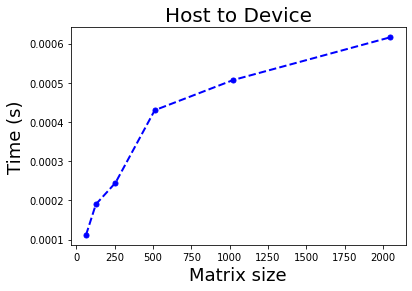

In [11]:
import matplotlib.pyplot as plt

plt.plot([64, 128, 256, 512, 1024, 2048],[0.000112, 0.000190, 0.000245, 0.000430, 0.000507, 0.000616], 'bo--', linewidth=2, markersize=5)
plt.title('Host to Device', fontsize=20)
plt.xlabel('Matrix size', fontsize=18)
plt.ylabel('Time (s)', fontsize=18)

Text(0, 0.5, 'Time (s)')

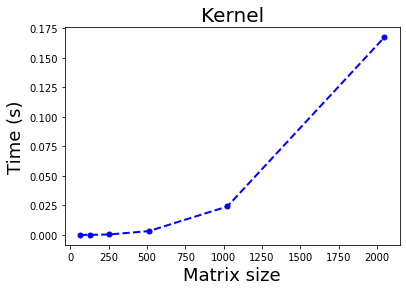

In [12]:
import matplotlib.pyplot as plt

plt.plot([64, 128, 256, 512, 1024, 2048],[0.000087, 0.000149, 0.000502, 0.003296, 0.024171, 0.167482], 'bo--', linewidth=2, markersize=5)
plt.title('Kernel', fontsize=20)
plt.xlabel('Matrix size', fontsize=18)
plt.ylabel('Time (s)', fontsize=18)

Text(0, 0.5, 'Time (s)')

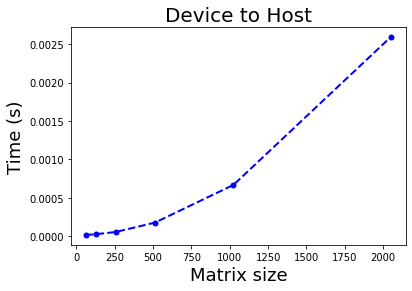

In [14]:
import matplotlib.pyplot as plt

plt.plot([64, 128, 256, 512, 1024, 2048],[0.000016, 0.000025, 0.000054, 0.000176, 0.000667, 0.002590], 'bo--', linewidth=2, markersize=5)
plt.title('Device to Host', fontsize=20)
plt.xlabel('Matrix size', fontsize=18)
plt.ylabel('Time (s)', fontsize=18)